Imports
---------

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_df = pandas.read_csv('./movie_metadata.csv')

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 10 columns):
duration                  4515 non-null float64
num_voted_users           4537 non-null float64
num_critic_for_reviews    4506 non-null float64
movie_facebook_likes      4548 non-null float64
imdb_score                4535 non-null float64
budget                    4097 non-null float64
gross                     3754 non-null float64
title_year                4436 non-null float64
director_name             4442 non-null object
movie_title               4543 non-null object
dtypes: float64(8), object(2)
memory usage: 394.1+ KB


In [4]:
raw_df.describe()

,duration,num_voted_users,num_critic_for_reviews,movie_facebook_likes,imdb_score,budget,gross,title_year
count,4515.000000,4.537000e+03,4506.000000,4548.000000,4535.000000,4.097000e+03,3.754000e+03,4436.000000
mean,107.383167,8.333643e+04,140.585220,7353.018030,6.442007,4.046311e+07,4.826140e+07,2002.512173
std,25.552032,1.362740e+05,122.370783,19037.627603,1.126033,2.167828e+08,6.843258e+07,12.455977
min,7.000000,5.000000e+00,1.000000,0.000000,1.600000,2.180000e+02,1.620000e+02,1916.000000
25%,93.000000,8.693000e+03,50.000000,0.000000,5.800000,6.000000e+06,5.402379e+06,1999.000000
50%,104.000000,3.453200e+04,110.000000,157.000000,6.600000,2.000000e+07,2.538322e+07,2005.000000
75%,118.000000,9.586000e+04,195.750000,3000.000000,7.200000,4.500000e+07,6.095299e+07,2011.000000
max,511.000000,1.676169e+06,813.000000,349000.000000,9.500000,1.221550e+10,7.605058e+08,2016.000000


Toy Problem
-----------------

In this basic analysis I will try to answer a business question - which director should the company invest in the future?
I'll go through stages, refining the analysis as I progress

Cleaning the data / filling in missing values
------------------

To avoid data loss, I decided to apply the following cleaning strategy:
    1. For gross,budget and year assign the mean.
    2. If all gross/budget values for a director == NaN, remove the director
    3. Remove unknown directors

In [5]:
for col in ['gross','budget','title_year']:
    mean = raw_df.groupby('director_name').mean()[col]
    mean_col = raw_df.groupby('director_name').mean()[col]
    relevant_directors = mean_col.dropna().index
    raw_df = raw_df.set_index('director_name').loc[relevant_directors].reset_index()
    na_col = raw_df[raw_df[col].isnull()].apply(lambda x: x.set_value(col,mean_col[x['director_name']]),axis=1)[col]
    raw_df.ix[raw_df[col].isnull(),col] = na_col

raw_df['title_year'] = raw_df['title_year'].apply(lambda x: np.round(x))

**Who is the most revenue generating director?**

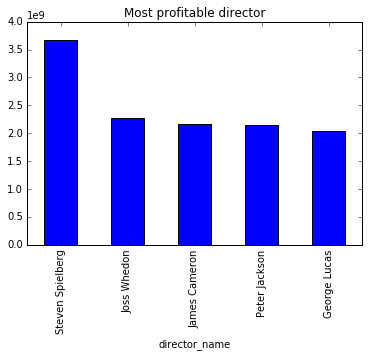

In [6]:
raw_df.groupby('director_name')\
      .sum()\
      .sort_values(by='gross',ascending=False)\
      .head()['gross'].plot(kind='bar',title="Most profitable director");

Revenue is not enough, we are actually interested in revenue/budget.

Normalized by budget: (Director with highest ROI)

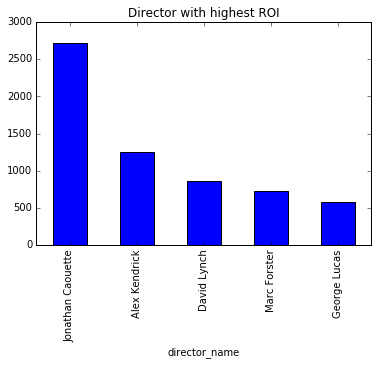

In [7]:
raw_df['gross_d_budget'] = raw_df['gross'] / raw_df['budget']
raw_df.groupby('director_name')\
      .sum()\
      .sort_values(by='gross_d_budget',ascending=False)\
      .head()['gross_d_budget'].plot(kind='bar',title="Director with highest ROI")

Directors with few movies do not have enough experience. Let's look only at directors with more than 5 movies:

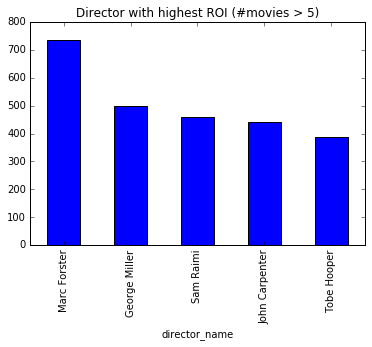

In [8]:
raw_df['dummy_count'] = 1 #Easier than count..
raw_df.groupby('director_name')\
      .sum()\
      .query('dummy_count > 5')\
      .sort_values(by='gross_d_budget',ascending=False)\
      .head()['gross_d_budget'].plot(kind='bar',title="Director with highest ROI (#movies > 5)")

The sum of gross/budget isn't actually a good enough measure for success. Here is the example:

In [9]:
top_dirs = raw_df.groupby('director_name')\
      .sum()\
      .query('dummy_count > 5')\
      .sort_values(by='gross_d_budget',ascending=False)\
      .head().index

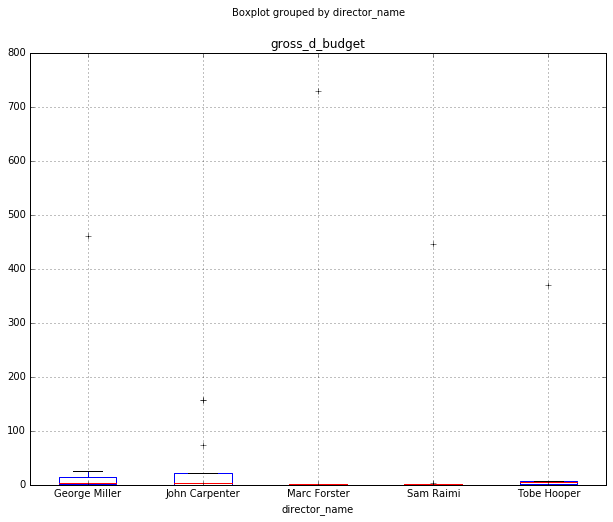

In [10]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
raw_df.set_index('director_name').loc[top_dirs].reset_index().boxplot(column='gross_d_budget',by='director_name',ax=ax);

For most directors in the plot, we can see there are outliers , very far from the mean.
One incredibly successful film can bias our decision. We want a more reliable investment, in a director that has a more certain ROI. Let's examine the director high the higest mean (and more than 5 films)

In [11]:
more5_films = raw_df.set_index('director_name').loc[raw_df.groupby('director_name').count().reset_index().query('gross > 5')['director_name']].reset_index()

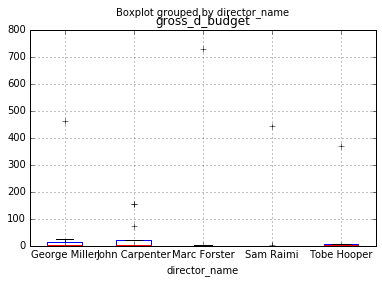

In [12]:
top_dirs = more5_films.groupby('director_name')\
      .mean()\
      .sort_values(by='gross_d_budget',ascending=False)\
      .head().index;
raw_df.set_index('director_name').loc[top_dirs].reset_index().boxplot(column='gross_d_budget',by='director_name');

Still, in our list there are directors with outliers that could bias our decision. let's discard the ones with std higher than the mean-std (we are interested in a solid investment)

In [13]:
mean_std = more5_films.std()['gross_d_budget']
solid_directors = more5_films.groupby('director_name').std().query('gross_d_budget < '+str(mean_std)).index

In [14]:
top_dirs = more5_films.set_index('director_name').loc[solid_directors].reset_index()\
.groupby('director_name')\
.mean()\
.sort_values(by='gross_d_budget',ascending=False)[:5].index

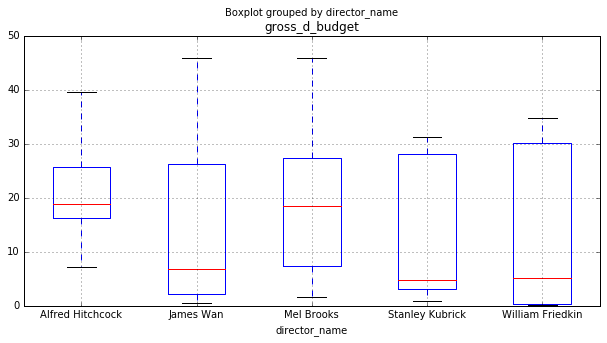

In [15]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
more5_films.set_index('director_name').loc[top_dirs].reset_index().boxplot(column='gross_d_budget',by='director_name',ax=ax);

**Conclusion:**
According to this analysis, Alfred Hitchcock has the best ROI, Mel Brooks is probably next. 
Since A.Hitchcock isn't active, we may want to continue screening for directors who are active in the last years, have an upward trend in gross/budget and lower std.

Basic exploratory analysis
----------------------------

In [16]:
raw_df = pandas.read_csv('./movie_metadata.csv')

First, I want to see some basic information about the features such as spearman correlation coef

In [17]:
raw_df.corr()

,duration,num_voted_users,num_critic_for_reviews,movie_facebook_likes,imdb_score,budget,gross,title_year
duration,1.000000,0.325141,0.246960,0.195136,0.260817,0.073824,0.257127,-0.147181
num_voted_users,0.325141,1.000000,0.631831,0.543541,0.409239,0.071839,0.641381,0.003733
num_critic_for_reviews,0.246960,0.631831,1.000000,0.687555,0.316127,0.115818,0.479226,0.276938
movie_facebook_likes,0.195136,0.543541,0.687555,1.000000,0.242130,0.060281,0.381995,0.220457
imdb_score,0.260817,0.409239,0.316127,0.242130,1.000000,0.032554,0.203455,-0.204328
budget,0.073824,0.071839,0.115818,0.060281,0.032554,1.000000,0.088690,0.042634
gross,0.257127,0.641381,0.479226,0.381995,0.203455,0.088690,1.000000,0.053051
title_year,-0.147181,0.003733,0.276938,0.220457,-0.204328,0.042634,0.053051,1.000000


**Trying to see trends and correlations in the data - high level overview**

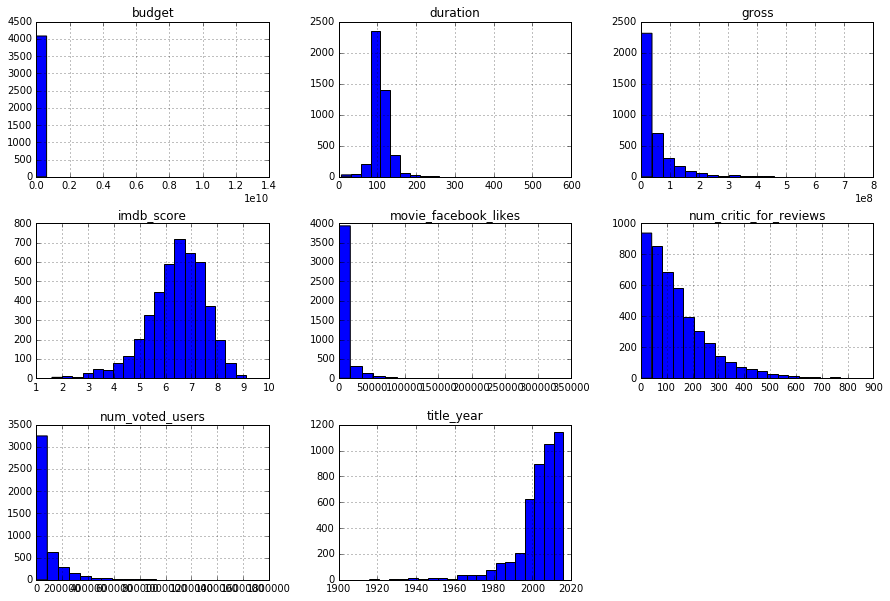

In [18]:
raw_df.hist(figsize=(15,10),bins=20);

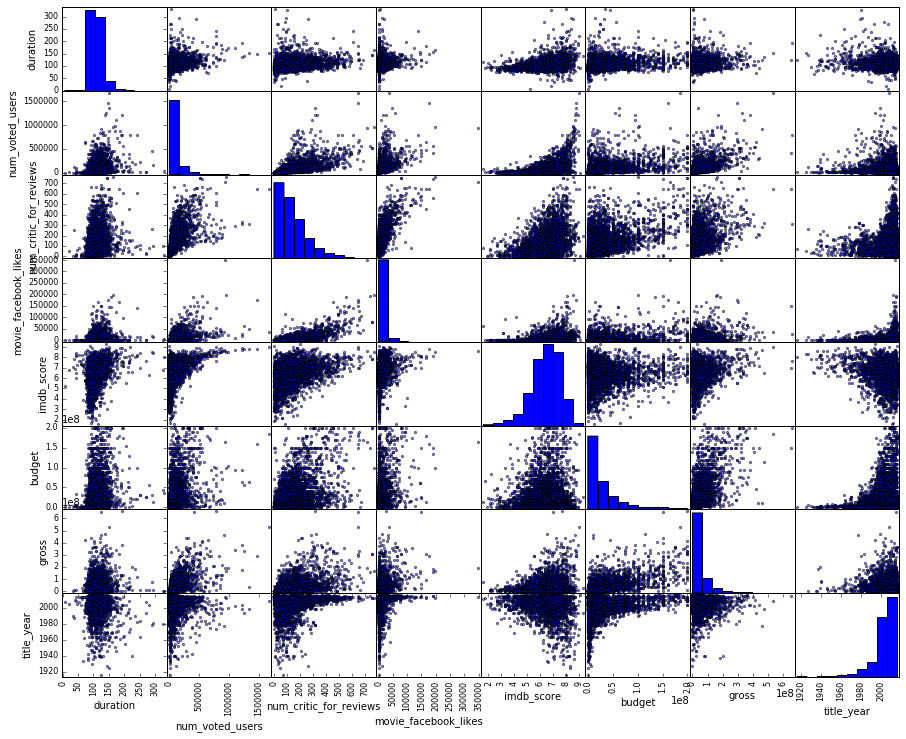

In [19]:
from pandas.tools.plotting import scatter_matrix
budget_cutoff = raw_df['budget'].quantile(0.99)#outlier skew the graph
scatter_matrix(raw_df.query('budget < '+str(budget_cutoff)),figsize=(15,12)); 

I witness a medium-strength correlation between gross and num_voted_users. Let's measure the statistical significance of this correlation coefficient value:

In [20]:
from scipy.stats import spearmanr
corrdf = raw_df[['gross','num_voted_users']].dropna()
print "The p-value is " + str(spearmanr(corrdf['gross'].dropna(),corrdf['num_voted_users']).pvalue)

The p-value is 0.0


PCA
---
PCA is a great way to inspect multivariate behaviour of data.
Since the dataset contains a lot of blanks, and PCA required no-blank dataset, I decided to fill the missing numeric values with the mean for each director , or the total mean where there is only one entry for that director.

In [21]:
for col in raw_df.columns:
    if col in ['director_name','movie_title']:
        continue
    mean = raw_df.mean()[col]
    mean_col = raw_df.groupby('director_name').mean()[col]
    for row_i, row_data in raw_df.iterrows():
        if np.isnan(row_data[col]):
            if row_data['director_name'] is np.nan and np.isnan(row_data[col]):
                raw_df.ix[row_i,col] = mean
                continue
            mean_director = mean_col[row_data['director_name']]
            if np.isnan(mean_director):
                raw_df.ix[row_i,col] = mean
            else:
                raw_df.ix[row_i,col] = mean_director
        
    
raw_df['title_year'] = raw_df['title_year'].apply(lambda x: np.round(x))
num_null_dirs = len(np.where(raw_df['director_name'].isnull())[0])
raw_df.ix[raw_df['director_name'].isnull(),'director_name'] = np.random.choice(raw_df['director_name'].dropna(),num_null_dirs)

In [22]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pca = PCA()
pca_pipeline = Pipeline((('scaler',scaler),('pca',pca)))

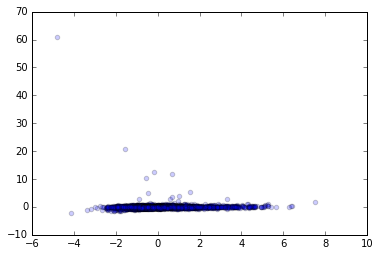

In [23]:
pca_res = pca_pipeline.fit_transform(raw_df.drop(['director_name','movie_title'],axis=1))
pca1 = pca_res[:,1]
pca2 = pca_res[:,2]
plt.scatter(pca1,pca2,alpha=0.2);

Same plot with outliers removed

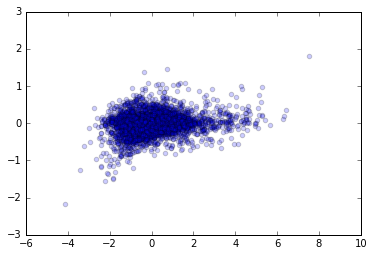

In [24]:
ind = np.where(pca2 < 2)
plt.scatter(pca1[ind],pca2[ind],alpha=0.2);